Origin-destination matrix estimation

Possibly useful for constructing P matrix: probability of going through edges when moving from A to B

- https://openrouteservice.org/services/  (e.g. nearest)
- Google Maps API, maybe Google Distance Matrix API, maybe Google Geotagging API
- https://www.opentripplanner.org/ (Helps: https://github.com/jeromemayaud/OpenTripPlanner-OD-matrix)
Directions API: Directions between multiple locations, Distance Matrix API: Travel times and distances between locations<br>
Routes API: Performance optimized versions of the Directions and Distance Matrix APIs<br>
Roads API: Snap-to-road functionality to accurately trace GPS breadcrumbs.  maybe Places API

"QNEAT3 OD Matrix Calculation": https://github.com/kahlulz/Olongapo-City-Hospital-Network-Analysis<br>
Spatial Analysis: QGIS is utilized to conduct spatial analysis. Hospital locations were mapped, and distance-based calculations were performed using QNEAT3 OD Matrix Calculation. <br>
https://gis.stackexchange.com/questions/403556/what-unit-is-represented-by-od-matix-costs-in-qneat3-within-qgis-3-6-noosa?newreg=400dd6f344ab480a959ecfc8002019b9 <br>
https://root676.github.io/OdMatrixAlgs.html <br>
https://www.qgistutorials.com/en/docs/3/origin_destination_matrix.html

In [1]:
import map_functions
import computing_functions

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

gdf = gpd.read_file("data/sources/Hungary_2022_static_road_data.geojson")

In [2]:
geo_positions = {
    "Budapest": (47.497912, 19.040235),
    "Kecskemét": (46.906770, 19.691383),
    "Szeged": (46.253000, 20.141424),
    "Szolnok": (47.172424, 20.178190),
    "Debrecen": (47.531605, 21.627312),
    "Nyíregyháza": (47.955879, 21.716837),
    "Miskolc": (48.104385, 20.791731),
    "Dunaújváros": (46.961511, 18.940582),
    "Szekszárd": (46.348886, 18.706048),
    "Pécs": (46.072734, 18.232266),
    "Székesfehérvár": (47.186644, 18.422595),
    "Siófok": (46.911703, 18.040138),
    "Győr": (47.687453, 17.634782),
    "Sopron": (47.686567, 16.588856),
    "Szombathely": (47.130884, 16.621046),
    "div_point_Miskolc_Debrecen": (47.7, 20.2),
    "div_point_Debrecen_Nyíregyháza": (47.6, 20.8),
    "div_point_Sopron_Szombathely": (47.4, 17.2),
    "Veszprém": (47.093658, 17.911332)
}

## P-matrix: paths with Google

Google returns only 3 opportunities, and it's hard to tell how they map to our system.

In [ ]:
import json
key = json.loads(open('keys.json').read())[""]

In [ ]:
import googlemaps

gmaps = googlemaps.Client(key=key)
directions_result = gmaps.directions("Hegyeshalom", "Mosonszolnok", alternatives=True)
#Possible directions test
for i, route in enumerate(directions_result):
    print(f"Route {i+1}:")
    for step in route['legs'][0]['steps']:  
        print(step['html_instructions'])
    print("\n\n")

Route 1:
Head <b>southwest</b> on <b>Alkotmány u.</b>
Turn <b>left</b>
Turn <b>right</b> at <b>Orgona u.</b>
Turn <b>right</b>
Turn <b>left</b>
Continue onto <b>Szabadság út</b>
Turn <b>right</b> onto <b>Jókai u.</b><div style="font-size:0.9em">Destination will be on the right</div>



Route 2:
Head <b>northeast</b> on <b>Alkotmány u.</b> toward <b>Damjanich u.</b>
Turn <b>right</b> onto <b>Damjanich u.</b>
Turn <b>left</b> onto <b>Szolnoki u.</b>
Continue onto <b>Kertalja u.</b>
Turn <b>right</b> onto <b>Fő u.</b>/<wbr/><b>Route 1</b><div style="font-size:0.9em">Continue to follow Route 1</div>
At the roundabout, take the <b>3rd</b> exit and stay on <b>Route 1</b>
At the roundabout, take the <b>2nd</b> exit and stay on <b>Route 1</b>
Turn <b>right</b> onto <b>Szolnoki út</b>
Continue onto <b>Óvári u.</b>
Continue onto <b>Fő u.</b>
Turn <b>left</b> onto <b>Szabadság út</b>
Turn <b>right</b> onto <b>Jókai u.</b><div style="font-size:0.9em">Destination will be on the right</div>



Route

## P-matrix for a small case: computing based on shortest paths

(give back all shortest paths, and 1/n on each path (+multiplicalities), 0 elsewhere..)

In [3]:
import pickle
with open("networks/Hungary_major_connections_upgraded_no_IDs.gpickle", "rb") as f:
    G_simple = pickle.load(f)

In [4]:
pos = {city: (lon, lat) for city, (lat, lon) in geo_positions.items()}#Just converting to dict (map) format for networkx

#Rename node names for better visualization
node_names = {city: city for city in pos.keys()}
node_names['div_point_Miskolc_Debrecen'] = 'd_M_D'
node_names['div_point_Debrecen_Nyíregyháza'] = 'd_D_Ny'
node_names['div_point_Sopron_Szombathely'] = 'd_S_Sz'

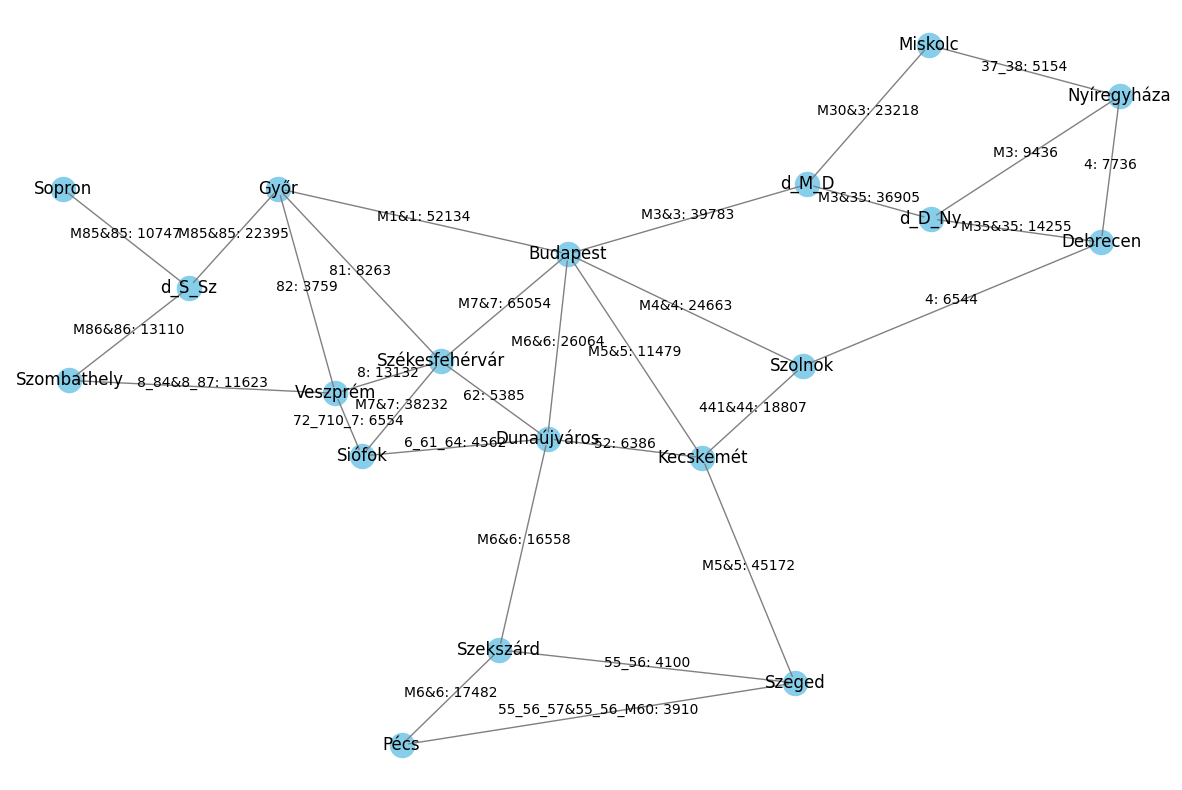

In [5]:
map_functions.plot_map_simple_graph(G_simple, pos, node_names)

E.g. shortest paths:

In [6]:
roads = list(G_simple.edges())
road_traffics = [G_simple.get_edge_data(road[0], road[1])['weight'] for road in roads]

locations = list(G_simple.nodes())
#locations.remove('div_point_Miskolc_Debrecen'); locations.remove('div_point_Debrecen_Nyíregyháza'); locations.remove('div_point_Sopron_Szombathely')
shortest_paths_dict = {}
for i in range(len(locations)):
    source = locations[i]
    for j in range(i+1,len(locations)):
        target = locations[j]
        if source != target:
            paths = nx.all_shortest_paths(G_simple, source=source, target=target)
            shortest_paths_dict[(source, target)] = list(paths)

In [7]:
extra_paths = computing_functions.create_paths_dict([['Budapest', 'div_point_Miskolc_Debrecen', 'div_point_Debrecen_Nyíregyháza', 'Debrecen']])
hidden_locs = ['div_point_Miskolc_Debrecen', 'div_point_Debrecen_Nyíregyháza', 'div_point_Sopron_Szombathely']
v, P, odm, extra = computing_functions.v_P_odmbp_shortest_paths(G_simple, hidden_locations=hidden_locs, extra_paths_dict = extra_paths)
v_reduced, P_reduced, odm_reduced, extra_reduced = computing_functions.v_P_odmbp_reduced_matrix(G_simple, hidden_locations=hidden_locs, extra_paths_dict = extra_paths)

Sympy measured higher rank than numpy, extra steps are needed to take
Deleted rows list (index): [2]


There was an issue with Sympy giving different rank result than numpy (possibly the issue comes from digits accuracy). This seems to be fixed by the new approach.<br>
This is also stated here: [SymPy rank different from NumPy matrix rank](https://stackoverflow.com/questions/53792657/sympy-rank-different-from-numpy-matrix-rank)

In [8]:
np.linalg.matrix_rank(P_reduced), P_reduced.shape

(29, (29, 120))

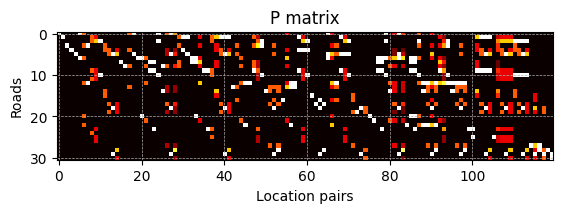

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
cax = ax.imshow(P, cmap='hot', interpolation='nearest')
#fig.colorbar(cax)
ax.set_title('P matrix')
ax.set_xlabel('Location pairs')
ax.set_ylabel('Roads')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [10]:
from scipy.io import savemat

#Save the P matrix in a .mat file
savemat('computing/P/P_matrix_16_cities.mat', {'P': P})
np.savetxt("computing/P/P_matrix_16_cities.csv", P, delimiter=",", fmt='%.3f')
np.savetxt("computing/P/P_matrix_reduced_16_cities.csv", P_reduced, delimiter=",", fmt='%.3f')

## Constrainted optimization: SciPy

**NOTE**: We need to try out stronger solvers, as SciPy really only optimizes locally.

A pre-computed ODM (although for a different equation):

In [11]:
odm_entropy_max_previous_df = pd.read_csv("computing/odm/ODM_16_cities_entropy_max_previous.csv")
loc_pairs_pre = odm_entropy_max_previous_df['location_pair']
odm_entropy_max_previous = odm_entropy_max_previous_df['ODM_value']

Initial steps:

In [12]:
from scipy.optimize import minimize, Bounds, LinearConstraint

#Objective function
def entropy_max(odm):
    #Entropy maximizing (== minimizing the negative entropy)
    return np.sum(odm * np.log(odm))

def entropy_max_derivative(x): 
    return np.log(x) + 1

def entropy_min(odm):
    return -np.sum(odm * np.log(odm))

def entropy_min_derivative(x):
    return -np.log(x) - 1

#Constraint(s)
def constraint_eq_reduced(odm):
    return P_reduced @ odm - v_reduced
def constraint_eq(odm):
    return P @ odm - v

constraints = {'type': 'eq', 'fun': constraint_eq}
constraints_reduced = {'type': 'eq', 'fun': constraint_eq_reduced}
constraints_linear = LinearConstraint(P_reduced, lb=v_reduced, ub=v_reduced)

bounds = Bounds(0.001, 100000) #np.inf
result = minimize(entropy_max, odm_entropy_max_previous, constraints=constraints_linear, bounds=bounds) #jac=entropy_derivative
optimal_odm = result.x

c:\Users\hanic\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


### Nonlinear constraint

#### Entropy maximization

In [13]:
result = minimize(entropy_max, odm_reduced, constraints=constraints_reduced, bounds=bounds,) #jac=entropy_derivative
optimal_odm = result.x

In [14]:
print('Success:', result.success)
print('Message:', result.message)

Success: False
Message: Iteration limit reached


Turns out a full 1s initial O-D matrix makes this pretty bad. All values are < 10, got stuck in a local minimum. Maybe a better initial guess would help.

Let's try with `odm_entropy_max_previous`.

In [15]:
result = minimize(entropy_max, odm_entropy_max_previous, constraints=constraints_reduced, bounds=bounds,) #jac=entropy_derivative
optimal_odm = result.x
print('Success:', result.success)
print('Message:', result.message)
optimal_odm_list = []
for i in range(10):
    res = minimize(entropy_max, optimal_odm, constraints=constraints_reduced, bounds=bounds, jac = entropy_max_derivative, )
    optimal_odm = res.x
    optimal_odm_list.append(optimal_odm)
    print('Message:', res.message)

Success: False
Message: Iteration limit reached
Message: Iteration limit reached
Message: Iteration limit reached
Message: Iteration limit reached
Message: Iteration limit reached
Message: Iteration limit reached
Message: Iteration limit reached
Message: Iteration limit reached
Message: Iteration limit reached
Message: Iteration limit reached
Message: Iteration limit reached


Not much changed over the last runs as I see it.

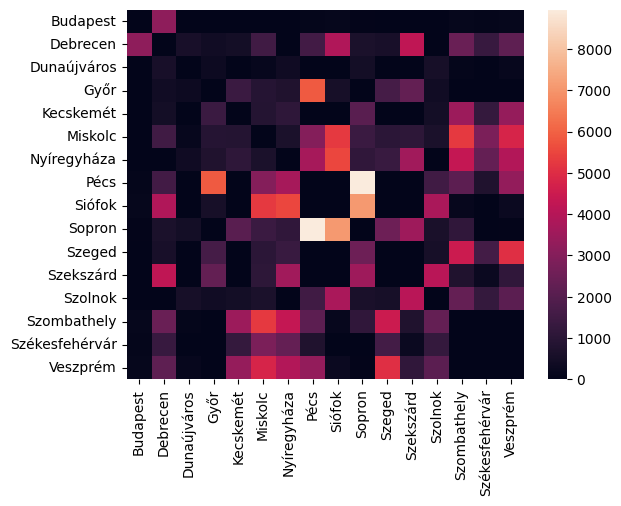

In [16]:
odm_2d,odm_locations = computing_functions.get_odm_2d_symmetric(odm = optimal_odm, location_pairs=extra_reduced['location_pairs'])
computing_functions.plot_odm(odm_2d, odm_locations)

In [20]:
df1 = pd.DataFrame({
    #'location_pair': extra_reduced['location_pairs'],
    'origin': [pair[0] for pair in extra_reduced['location_pairs']],
    'destination': [pair[1] for pair in extra_reduced['location_pairs']],
    'ODM_value': optimal_odm_list[-1]
})
df1.to_csv('computing/odm/ODM_16_cities_entropy_max.csv', index=False)

Looking into it, entropy maximization doesn't really seem like a good method.. it puts too much weight on far distances.

#### Entropy minimization

In [21]:
result = minimize(entropy_min, odm_entropy_max_previous, constraints=constraints_reduced, bounds=bounds,) #jac=entropy_derivative
optimal_odm = result.x
print('Success:', result.success)
print('Message:', result.message)
optimal_odm_list = []
for i in range(10):
    res = minimize(entropy_min, optimal_odm, constraints=constraints_reduced, bounds=bounds, jac = entropy_min_derivative)
    optimal_odm = res.x
    optimal_odm_list.append(optimal_odm)
    print('Message:', res.message)

c:\Users\hanic\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Success: False
Message: Iteration limit reached
Message: Positive directional derivative for linesearch
Message: Positive directional derivative for linesearch
Message: Positive directional derivative for linesearch
Message: Positive directional derivative for linesearch
Message: Positive directional derivative for linesearch
Message: Positive directional derivative for linesearch
Message: Positive directional derivative for linesearch
Message: Positive directional derivative for linesearch
Message: Positive directional derivative for linesearch
Message: Positive directional derivative for linesearch


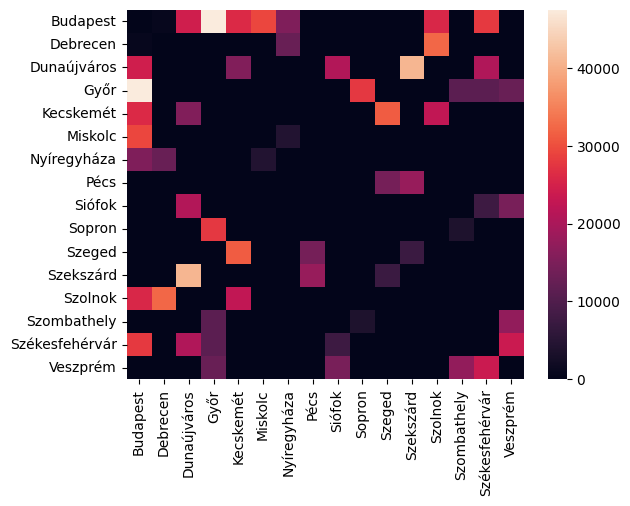

In [22]:
odm_2d,odm_locations = computing_functions.get_odm_2d_symmetric(odm = optimal_odm, location_pairs=extra_reduced['location_pairs'])
computing_functions.plot_odm(odm_2d, odm_locations)

In [23]:
df2 = pd.DataFrame({
    #'location_pair': extra_reduced['location_pairs'],
    'origin': [pair[0] for pair in extra_reduced['location_pairs']],
    'destination': [pair[1] for pair in extra_reduced['location_pairs']],
    'ODM_value': optimal_odm
})
df2.to_csv('computing/odm/ODM_16_cities_entropy_min.csv', index=False)

### Linear constraint

In [ ]:
result = minimize(entropy_max, odm_entropy_max_previous, constraints=constraints_linear, bounds=bounds) #jac=entropy_derivative
optimal_odm = result.x
print('Success:', result.success)
print('Message:', result.message)
optimal_odm_list = []
for i in range(10):
    res = minimize(entropy_max, optimal_odm, constraints=constraints_linear, bounds=bounds, jac = entropy_max_derivative)
    optimal_odm = res.x
    optimal_odm_list.append(optimal_odm)
    print('Message:', res.message)

c:\Users\hanic\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Success: False
Message: Iteration limit reached
Message: Iteration limit reached
Message: Iteration limit reached
Message: Iteration limit reached
Message: Iteration limit reached
Message: Iteration limit reached
Message: Iteration limit reached
Message: Iteration limit reached
Message: Iteration limit reached
Message: Iteration limit reached
Message: Iteration limit reached


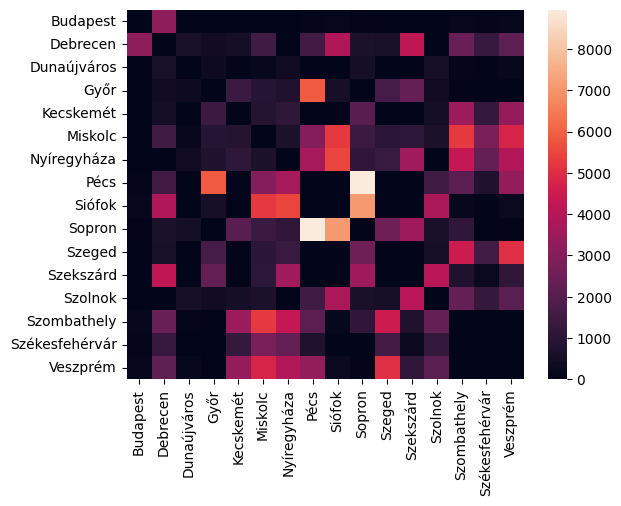

In [ ]:
odm_2d,odm_locations = computing_functions.get_odm_2d_symmetric(odm = optimal_odm, location_pairs=extra_reduced['location_pairs'])
computing_functions.plot_odm(odm_2d, odm_locations)

### Bell-model

## Other methods (not SciPy)

Because SciPy is not very good at global optimization, we will need to try other methods.

### CyIPOPT

Currently being tried to be installed.

<details><summary>Code</summary>

```python

import numpy as np
import cyipopt

#Entropy maximizing
def eval_f(x, user_data=None):
    return np.sum(x * np.log(x))

#Gradient
def eval_grad_f(x, user_data=None):
    return np.log(x) + 1

#Constraints
def eval_g(x, user_data=None):
    return P_reduced @ x - v_reduced

#Jacobian of the constraints
def eval_jac_g(x, flag,): #user_data=None
    if flag:
        return np.nonzero(P_reduced)
    else:
        return P_reduced.flatten()

constraints = [{'type': 'eq', 'fun': eval_g, 'jac': eval_jac_g}]
#Bounds (for each dimension of the input) 
bounds = [(0.001, 100000) for _ in range(len(odm_entropy_max_previous))]

nlp = cyipopt.Problem(
    n=len(odm_entropy_max_previous),
    m=len(P_reduced),
    problem_obj=eval_f,
    grad_obj=eval_grad_f,
    g=eval_g,
    jac_g=eval_jac_g,
    lb=[b[0] for b in bounds],
    ub=[b[1] for b in bounds],
)

x, info = nlp.solve(odm_entropy_max_previous)

```

</details>

## Regularized optimization

Instead of using constraints, we can use a regularized optimization, like L1 or L2 regularization.<br>
This way, we do not have to care about singularities, and we do not have to drop any constraint equations.